# Course Project: Mercari Price Predictions
https://www.kaggle.com/c/mercari-price-suggestion-challenge/overview

Name: Cory Kaye

A#: A01806152

In [724]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from scipy.sparse import vstack, hstack, csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import Ridge

# Create datasets from files

In [725]:
# Create training dataset
train = pd.read_csv('train_medium.tsv', sep = '\t') # The slimmed down version containing less records
# train = pd.read_csv('train.tsv', sep = '\t') # Full data
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [726]:
# Create testing set
test = pd.read_csv('test_small.tsv', sep = '\t',engine = 'python') # The slimmed down version containing less records
# test = pd.read_csv('test.tsv', sep = '\t',engine = 'python') # Full data

In [727]:
# Create y_price variable, log based
y = np.log1p(train['price'])

In [728]:
# Create combined set, for preprocessing so we have all text data in one place
combined = pd.concat([train,test])

# Keep track of the training set size
train_size = len(train)

In [729]:
combined.shape

(7002, 9)

# Preprocess text data

In [730]:
## Functions used to clean/normalize text data

from string import punctuation
# Use the built in list of punctions provided by string
punctuation_symbols = []
for symbol in punctuation:
    punctuation_symbols.append((symbol, '')) # create our string array

# Remove digits
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()])
    return x

# remove punctuations
import string
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

# Removing stopwords
# !pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')

def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

def to_lower(x):
    return x.lower()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Split category_name into separate categories

In [731]:
def split_category_data(category_name):
    try:
        main, s1, s2 = category_name.split('/')
        return main, s1, s2
    except:
        return np.nan, np.nan, np.nan

def split_and_add_subcat_data(dataset):
    dataset['category_main'], dataset['category_sub1'], dataset['category_sub2'] = zip(*dataset['category_name'].apply(split_category_data))

split_and_add_subcat_data(train)
split_and_add_subcat_data(test)

train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_main,category_sub1,category_sub2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [732]:
split_and_add_subcat_data(combined)

In [733]:
combined.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,test_id,category_main,category_sub1,category_sub2
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,NaN,Men,Tops,T-shirts
1,1.0,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,NaN,Electronics,Computers & Tablets,Components & Parts
2,2.0,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,NaN,Women,Tops & Blouses,Blouse
3,3.0,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,NaN,Home,Home Décor,Home Décor Accents
4,4.0,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,NaN,Women,Jewelry,Necklaces


In [734]:
# handle_missing_values
def handle_missing_values(dataset):
    dataset['category_name'].fillna(value='missing', inplace=True)
    dataset['category_main'].fillna(value='missing', inplace=True)
    dataset['category_sub1'].fillna(value='missing', inplace=True)
    dataset['category_sub2'].fillna(value='missing', inplace=True)
    dataset['brand_name'].fillna(value='None', inplace=True)
    dataset['item_description'].fillna(value='None', inplace=True)

In [735]:
# converting to make sure they are categorical data
def to_categorical(dataset):
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['category_main'] = dataset['category_main'].astype('category')
    dataset['category_sub1'] = dataset['category_sub1'].astype('category')
    dataset['category_sub2'] = dataset['category_sub2'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

Begin Preprocessing

In [736]:
handle_missing_values(combined)
to_categorical(combined)
combined.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,test_id,category_main,category_sub1,category_sub2
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,None,10.0,1,No description yet,NaN,Men,Tops,T-shirts
1,1.0,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,NaN,Electronics,Computers & Tablets,Components & Parts
2,2.0,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,NaN,Women,Tops & Blouses,Blouse
3,3.0,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,None,35.0,1,New with tags. Leather horses. Retail for [rm]...,NaN,Home,Home Décor,Home Décor Accents
4,4.0,24K GOLD plated rose,1,Women/Jewelry/Necklaces,None,44.0,0,Complete with certificate of authenticity,NaN,Women,Jewelry,Necklaces


In [737]:
def clean_and_standardize(dataset, column_name):
    dataset[column_name] = dataset[column_name].apply(remove_digits)
    dataset[column_name] = dataset[column_name].apply(remove_punctuation)
    dataset[column_name] = dataset[column_name].apply(remove_stop_words)
    dataset[column_name] = dataset[column_name].apply(to_lower)

def process_and_standardize_data(dataset):
    dataset.item_description = dataset.item_description.astype(str)

    clean_and_standardize(dataset, 'item_description')
    clean_and_standardize(dataset, 'name')
    clean_and_standardize(dataset, 'category_main')
    clean_and_standardize(dataset, 'category_sub1')
    clean_and_standardize(dataset, 'category_sub2')

process_and_standardize_data(combined)

combined.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,test_id,category_main,category_sub1,category_sub2
0,0.0,mlb cincinnati reds shirt size xl,3,Men/Tops/T-shirts,None,10.0,1,description yet,NaN,men,tops,tshirts
1,1.0,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,keyboard great condition works like came box p...,NaN,electronics,computers tablets,components parts
2,2.0,avaviv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top hint lace key hole back pale pink...,NaN,women,tops blouses,blouse


In [738]:
# Create the transform, for known words
cv = CountVectorizer(min_df=10)

# tokenize and create the vocabulary
X_train_name = cv.fit_transform(combined['name'])

In [739]:
# Create the transform, for known words
cv = CountVectorizer()

# tokenize and create vocbularies for each
X_train_category = cv.fit_transform(combined['category_name'])
X_train_category_main = cv.fit_transform(combined['category_main'])
X_train_category_sub1 = cv.fit_transform(combined['category_sub1'])
X_train_category_sub2 = cv.fit_transform(combined['category_sub2'])

In [740]:
# Create the transform, tfid better for non-known words that may happen
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')

# tokenize and create the vocabular
X_train_description = tv.fit_transform(combined['item_description'])

In [741]:
# better to use as we are only using a singular column
lb = LabelBinarizer(sparse_output=True)
X_train_brand = lb.fit_transform(combined['brand_name'])

Create CSR Matrix

In [742]:
# sparse_matrix for "better" array storage
X_train_dummies = csr_matrix(pd.get_dummies(combined[['item_condition_id', 'shipping']], sparse=True).values)

# add rest of categorics to sparse_matrix
sparse_merge = hstack((X_train_dummies, X_train_description, X_train_brand, X_train_category, X_train_category_main, X_train_category_sub1, X_train_category_sub2, X_train_name)).tocsr()

Split data into training data and test data

In [743]:
X_train_sparse = sparse_merge[:train_size]

X_test = sparse_merge[train_size:]

In [744]:
combined.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'test_id', 'category_main',
       'category_sub1', 'category_sub2'],
      dtype='object')

K-Fold Cross Validation

In [745]:
from sklearn.model_selection import KFold
kf = KFold(len(y))

for train_index, valid_index in kf.split(X_train_sparse):
    X_train, y_train = X_train_sparse[train_index], y[train_index]
    X_valid, y_valid = X_train_sparse[valid_index], y[valid_index]

X_train #so many elements even with a much smaller dataset

<5000x57382 sparse matrix of type '<class 'numpy.float64'>'
	with 183236 stored elements in Compressed Sparse Row format>

RMSLE Function

In [746]:
def rmsle(y, y0):
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y0), 2)))

# Make, Train, Eval Models

In [747]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
boosting_iterations = 128

Training, Predicting Validation, and Evaluating Test_Data with a GBDT Model

In [748]:
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt' # The main model
params['metric'] = 'rmse'

# Train the Model
gbdt_model = lgb.train(params, d_train, boosting_iterations)

# Predict using validation set
gbdt_pred = gbdt_model.predict(X_valid)
# convert predicted values back from log'd values
np.expm1(gbdt_pred)
# print RMSLE loss
print("RMSLE Loss: " + str(rmse(np.expm1(y_valid), np.expm1(gbdt_pred))))

# Predict using never before seen test data
gbdt_pred_final = gbdt_model.predict(X_test)
gbdt_pred_final = np.expm1(gbdt_pred_final)

RMSLE Loss: 0.13405511040060203


Training, Predicting Validation, and Evaluating Test_Data with a DART Model

In [749]:
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'dart' # The main model
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['drop_rate'] = 0.01

# Train the Model
dart_model = lgb.train(params, d_train, boosting_iterations)

# Predict using validation set
dart_pred = dart_model.predict(X_valid)
# convert predicted values back from log'd values
np.expm1(dart_pred)
# print RMSLE loss
print("RMSLE Loss: " + str(rmse(np.expm1(y_valid), np.expm1(dart_pred))))

# Predict using never before seen test data
dart_pred_final = dart_model.predict(X_test)
dart_pred_final = np.expm1(dart_pred_final)

RMSLE Loss: 0.14624846166347494


In [750]:
# Create our submission dataset
submission = test[['test_id']]
submission["price"] = np.expm1(gbdt_pred_final)
submission.to_csv("submission.csv", index = False)
print(submission)

      test_id         price
0           0  8.597185e+06
1           1  1.211809e+07
2           2  5.762090e+07
3           3  8.611751e+07
4           4  8.597185e+06
...       ...           ...
1996     1996  7.110148e+06
1997     1997  3.049059e+07
1998     1998  1.162063e+08
1999     1999  9.331794e+08
2000     2000  8.597185e+06

[2001 rows x 2 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


plot to show difference in predictions

<Figure size 720x288 with 0 Axes>

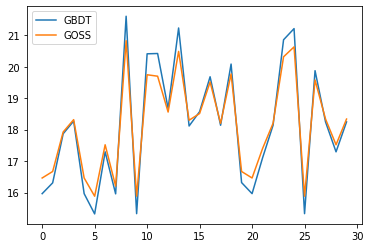

<Figure size 432x288 with 0 Axes>

In [751]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(gbdt_pred_final[:30], label = 'GBDT')
ax1.plot(dart_pred_final[:30], label = 'GOSS')

plt.legend(loc='upper left');
plt.show()
plt.savefig('plot.png', format='png')

Check total mean variance between two models

In [752]:
from statistics import mean
mean(abs(x - y) for x, y in zip(gbdt_pred_final, dart_pred_final))

0.34097980125167054